# Advanced EDA & Feature Engineering 
**Target**: Improving model input quality through advanced feature transformations and statistical validation.

### Business and technical context
This notebook represents the **experimental group** in our Churn prediction experiment. While the simple version focuses on raw data, this version introduces non-linear transformations and relative features to capture deeper behavioral patterns.

### Scope of work:
1. **Advanced Feature Engineering**: Log transformations, binning, and group-based scaling.
2. **Behavioral Indicators**: Creating density and ratio features (e.g., product density).

In [67]:
import pandas as pd
import numpy as np 
import torch 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [68]:
df = pd.DataFrame(pd.read_csv("../data/Bank Customer Churn Prediction.csv"))

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [70]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [71]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [72]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Feature Engineering & Data Transformation
**Goal**: Prepare features that better represent customer behavior and normalize distributions.
* **Log Transformation**: Applied to `balance` to reduce skewness and handle high variance.
* **Age Grouping**: Categorizing customers into 10-year cohorts for better segment analysis.
* **Group-based Scaling**: Calculating relative features (e.g., `s_credit_score`) by comparing individuals to their age group median.

In [73]:
df["age_group"]=(df["age"]/10).astype(int)

In [74]:
df['balance'] = np.log1p(df['balance'])

In [75]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,age_group
0,15634602,619,France,Female,42,2,0.000000,1,1,1,101348.88,1,4
1,15647311,608,Spain,Female,41,1,11.336294,1,0,1,112542.58,0,4
2,15619304,502,France,Female,42,8,11.980813,3,1,0,113931.57,1,4
3,15701354,699,France,Female,39,1,0.000000,2,0,0,93826.63,0,3
4,15737888,850,Spain,Female,43,2,11.740155,1,1,1,79084.10,0,4


In [76]:
df['age_group'].unique()

array([4, 3, 5, 2, 6, 1, 7, 8, 9])

In [77]:

df["s_credit_score"] = df["credit_score"]/df.groupby("age_group")["credit_score"].transform("median")
df["s_balance"] = df["balance"]/df.groupby("age_group")["balance"].transform("median")
df["s_salary"] = df["estimated_salary"]/df.groupby("age_group")["estimated_salary"].transform("median")
df["s_tenure"] = df["tenure"]/df.groupby("age_group")["tenure"].transform("median")

df['tenure_density'] = df['tenure'] / df['age_group']
df['product_density'] = df['products_number'] / df['age_group']

In [78]:
target = 'churn'
df = df[[c for c in df if c != target] + [target]]

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  age_group         10000 non-null  int64  
 12  s_credit_score    10000 non-null  float64
 13  s_balance         9991 non-null   float64
 14  s_salary          10000 non-null  float64
 15  s_tenure          10000 non-null  float64
 16  tenure_density    10000 non-null  float64

In [80]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [81]:
df['s_balance'] = df['s_balance'].fillna(df['s_balance'].median())

In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  age_group         10000 non-null  int64  
 12  s_credit_score    10000 non-null  float64
 13  s_balance         10000 non-null  float64
 14  s_salary          10000 non-null  float64
 15  s_tenure          10000 non-null  float64
 16  tenure_density    10000 non-null  float64

### Correlation analysis
**Goal** : Finding linear relationships between numerical features and the target variable.

We calculated the **Pearson correlation coefficient** for all numeric features.

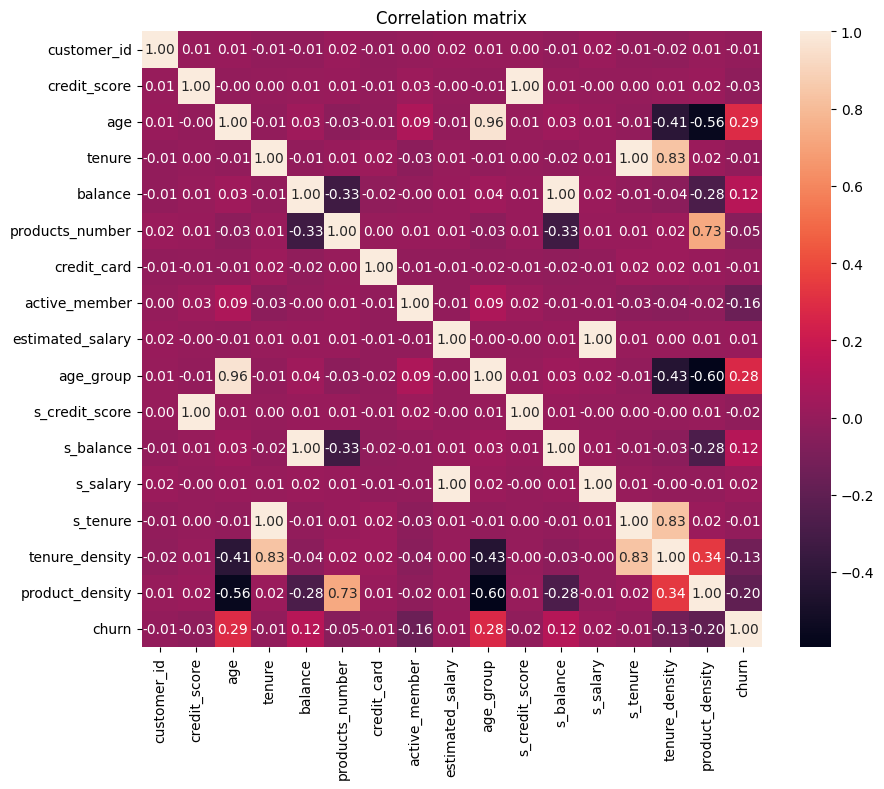

In [83]:
df_numeric =  df.select_dtypes(include=['number'])
corr_matrix=df_numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cbar=True)
plt.title("Correlation matrix")
plt.show()

The analysis identified seven features with a significant linear relationship to the target variable: `age`, `balance`, `active_member`, `age_group`, `s_balance`, `tenure_density`, and `product_density`.

* **Feature Interaction & Multicollinearity**: There is a high degree of correlation between the newly engineered features and their "parent" variables (e.g., `age` vs. `age_group`). This multicollinearity is expected, as many features are derivatives of the original data, and will be managed during the final feature selection to prevent model redundancy.

### Spearman Correlation analysis
**Goal** : Finding non-linear relationships between numerical features and the target variable.

We calculated the **Spearman correlation coefficient** for all numeric features.

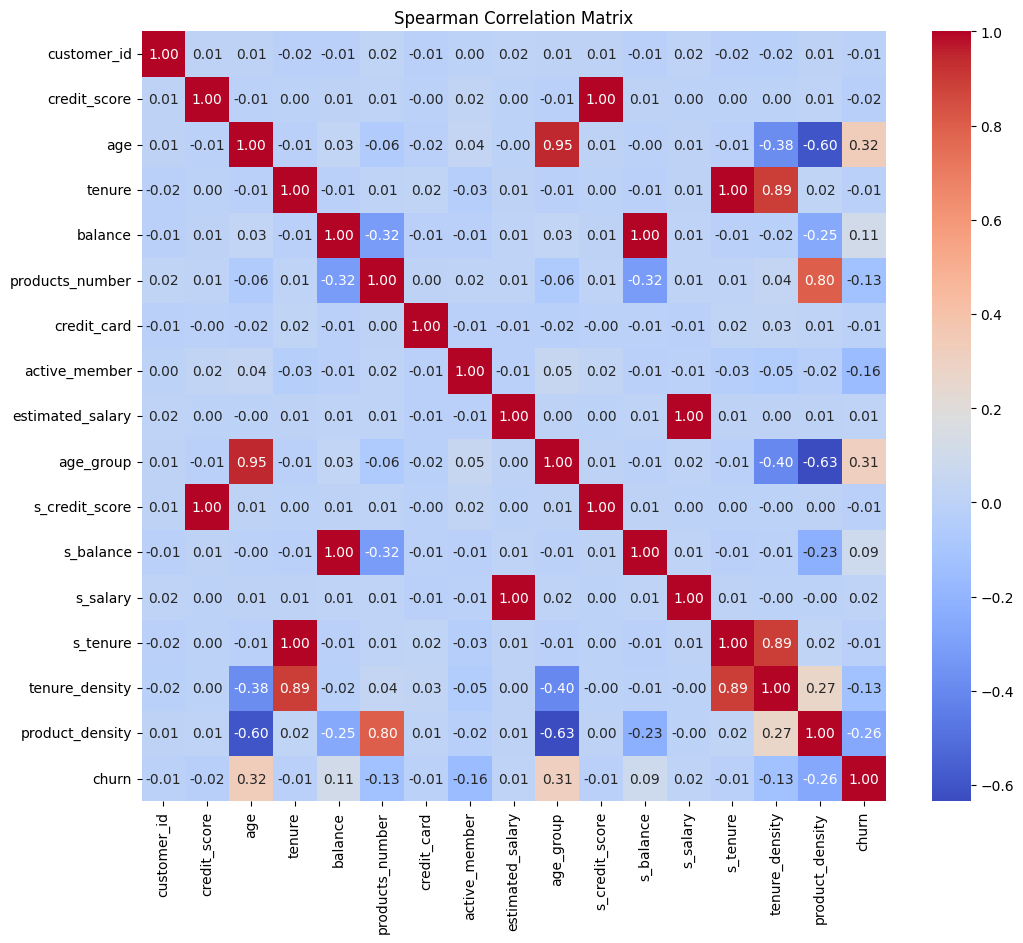

In [84]:
spearman_matrix = df.corr(method='spearman', numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(spearman_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Spearman Correlation Matrix")
plt.show()

**Findings**:
The **Spearman rank correlation** analysis did not identify any additional features with significant predictive power.

The lack of new discoveries in the Spearman test suggests that:
- The relationships in the dataset are either primarily linear or already effectively captured by our **Feature Engineering** (e.g., log transformations and ratios).
- While Spearman is effective for monotonic patterns, it may still miss complex, non-monotonic dependencies.

### Advanced Feature Selection: Mutual Information (MI)
**Goal**: To capture any type of statistical dependency—whether linear, non-linear, or complex—between the features and the target variable (`churn`).

**Methodology**:
We use `mutual_info_classif`, which is based on the principle of **entropy** and **Information Gain**. Unlike correlation coefficients (Pearson/Spearman), Mutual Information:
* Is capable of identifying features that are highly predictive even if their relationship with the target is complex (e.g., non-monotonic).

In [85]:

from sklearn.feature_selection import mutual_info_classif
X = df.select_dtypes(include=['number']).copy()
X = X.drop(columns=['churn', 'customer_id'], errors='ignore')

y = df['churn']

mi_scores = mutual_info_classif(X, y, random_state=42) 
mi_results = pd.Series(mi_scores, index=X.columns)

print(mi_results.sort_values(ascending=False))

product_density     0.094063
age                 0.075291
products_number     0.063105
age_group           0.062862
s_credit_score      0.049163
tenure_density      0.035323
s_balance           0.016029
active_member       0.010545
balance             0.005740
estimated_salary    0.002709
s_tenure            0.002128
s_salary            0.001712
tenure              0.000535
credit_card         0.000000
credit_score        0.000000
dtype: float64


### Conclusions from Mutual Information (MI) Analysis
The MI analysis provides a clear hierarchy of feature importance and validates the **Feature Engineering** strategy used in this "Solid" version of the notebook.

1. Success of Engineered Features
   * **Top Predictor**: `product_density` (0.094) has emerged as the most informative feature, surpassing even the strongest baseline variables like `age`.
   * **Effective Binning**: `age_group` (0.062) shows almost the same information gain as raw `age` (0.075), confirming that the 10-year cohorts effectively capture the age-related churn patterns.
   * **The Credit Score Paradox**: While the raw `credit_score` is statistically insignificant (.000), our engineered **`s_credit_score`** provides high predictive value (0.049), proving that combining age cohorts and financial data is far more informative than the raw value itself.

2. Weak and Irrelevant Features
   * **Redundancy**: `estimated_salary`, `s_salary`, and `tenure` they provide very little unique information.
   * **Zero Impact**: `credit_card` and `credit_score` have no detectable statistical dependency with the target variable.

### Statistical significance analysis (Chi-Square Test)
**Goal:** Verification of statistical significant relationship of categorical features `gender`, `county` and target variable `churn`.

**Methodology**
* **Null Hyphotesis $H_0$:** There is no relationship between the feature and customer churn.
* **Alternative Hyphotesis $H_1$:** There is a relationship between the feature and customer churn.

In [86]:
variables = ["country", "gender"]
target = "churn"
p = lambda p: p if p >= 0.05 else 0.0
for v in variables:
    tab = pd.crosstab(df[v], df[target])
    chi, p_val, dof, expected = stats.chi2_contingency(tab)
    print(f"Dla {v} p-value wynosi: {p(p_val)}.")


Dla country p-value wynosi: 0.0.
Dla gender p-value wynosi: 0.0.


**Conclusion**
For both `country` and `gender` the p-value is lower than 0.05.
- **Rejection of Null Hypothesiss**
- **Insights**
  - **Geography matters** - There are specifc customers behaviours in different countries.
  - **Gender matters** -  There is notable difference in customer behaviour between men and women. 

### Final Feature Selection & Leakage Prevention
**Goal:** Refining the dataset by removing features that pose a risk of data leakage.

**Methodology**
* **Data Leakage:** Dropping `s_tenure` , `s_balance` , `s_credit_score` and `s_salary` because they use global statistics, which could leak information from the test set.
* **Model Integration:** These features will be properly recreated within the model pipeline to ensure valid training and validation.
* **Feature Retention:** Other features are kept for now, as they are required as inputs to recreate the `s_` features within the model's pipeline.
* **Pipeline Drop:** Features `customer_id`, `credit_score`,`credit_card`,`tenure`,`age_group` and `estimated_salary` will be dropped in model's pipeline.

In [87]:
to_remove = ["s_salary","s_tenure","s_balance","s_credit_score"]
df_final = df.drop(columns=to_remove)

In [88]:
df_final.to_csv("../data/data_solid_eda.csv", index=False)